In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install keras-tcn

In [ ]:
from numpy import load
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

dict_data = load(r'/GMA/40_Frame/data_target_50_50/data_40_50_50.npz')
dict_target = load(r'/GMA/40_Frame/data_target_50_50/target_40_50_50.npz')

data = dict_data['arr_0']
target = dict_target['arr_0']

data_new = data/255.0 # normalize the data
data_new = np.round(data_new, 4)

train_labels = to_categorical(target, dtype ="uint8")

x_train, x_test, y_train, y_test = train_test_split(data_new, train_labels, test_size=0.1, random_state=42)

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from keras.optimizers import RMSprop 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import MaxPool2D

from tcn import TCN

num_samples = len(data_new)  # number of videos.
num_frames = len(data_new[0][:])  # 2,3,5 seconds of video at 20 ips.
h, w, c = data.shape[2], data.shape[3], 3  # def  video! color.

inputs = Input(shape=(num_frames, h, w, c)) 
x = Lambda(lambda y: K.reshape(y, (-1, h, w, c)))(inputs) # push num_frames in batch_dim to process all the frames independently of their orders (CNN features).
x = Conv2D(16, 5)(x) # apply convolutions to each image of each video.
x = MaxPool2D()(x)
    # re-creates the videos by reshaping.
    # 3D input shape (batch, timesteps, input_dim)
num_features_cnn = np.prod(K.int_shape(x)[1:]) # Returns the shape as a tuple of int or None entries # Return the product of array elements over a given axis.
x = Lambda(lambda y: K.reshape(y, (-1, num_frames, num_features_cnn)))(x)
    # apply the RNN on the time dimension (num_frames dim).
x = TCN(
    nb_filters=64,
    kernel_size=3,
    nb_stacks=1,
    dilations=(1, 2, 4, 8, 16, 32),
    padding='causal',
    use_skip_connections=True,
    dropout_rate=0.0,
    return_sequences=False,
    activation='relu',
    kernel_initializer='he_normal',
    use_batch_norm=False,
    use_layer_norm=False,
    use_weight_norm=False
)(x)

x = Dense(7, activation='softmax')(x)

model = Model(inputs=[inputs], outputs=[x])
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 50, 50, 3)]   0         
_________________________________________________________________
lambda (Lambda)              (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 16)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 40, 8464)          0         
_________________________________________________________________
tcn (TCN)                    (None, 64)                2302784   
_________________________________________________________________
dense (Dense)                (None, 7)                 455   

In [ ]:
print('Train...')
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, shuffle=True)

Train...
Epoch 1/10
39/39 [==============================] - 25s 556ms/step - loss: 16.7938 - accuracy: 0.3823 - val_loss: 1.5973 - val_accuracy: 0.6078
Epoch 2/10
39/39 [==============================] - 20s 502ms/step - loss: 0.5627 - accuracy: 0.8487 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 3/10
39/39 [==============================] - 20s 508ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 2.5012e-04 - val_accuracy: 1.0000
Epoch 4/10
39/39 [==============================] - 20s 510ms/step - loss: 0.4547 - accuracy: 0.9840 - val_loss: 0.0485 - val_accuracy: 0.9902
Epoch 5/10
39/39 [==============================] - 20s 510ms/step - loss: 0.0147 - accuracy: 0.9967 - val_loss: 3.2807e-04 - val_accuracy: 1.0000
Epoch 6/10
39/39 [==============================] - 20s 515ms/step - loss: 1.8442e-04 - accuracy: 1.0000 - val_loss: 2.4013e-05 - val_accuracy: 1.0000
Epoch 7/10
39/39 [==============================] - 20s 516ms/step - loss: 1.4685e-05 - accuracy: 1.0000 - val_loss:

In [ ]:
model.save_weights(r'E:\GMA\40_Frame\data_target_50_50/TCN_40_50_50.h5')

In [ ]:
result = model.evaluate(x_test, y_test)

6/6 [==============================] - 1s 121ms/step - loss: 1.1851e-08 - accuracy: 1.0000


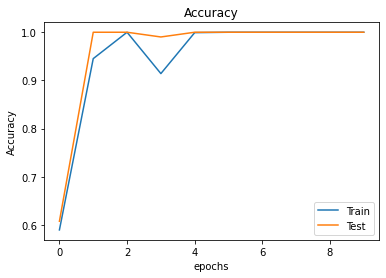

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()

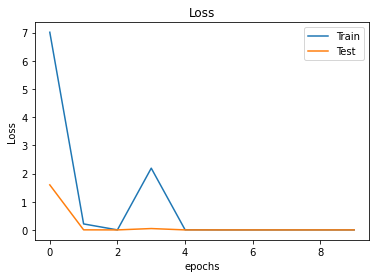

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

# label_predict = m
label_predict_argmax = np.argmax(model.predict(x_test), axis=-1)
label_actual_argmax = np.argmax(y_test, axis=-1)


cm = confusion_matrix(y_true=label_actual_argmax, y_pred=label_predict_argmax)


def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Purples):
   
    plt.imshow(cm, interpolation='nearest', aspect='auto', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=80)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[22  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0]
 [ 0  0 25  0  0  0  0]
 [ 0  0  0 17  0  0  0]
 [ 0  0  0  0 29  0  0]
 [ 0  0  0  0  0 31  0]
 [ 0  0  0  0  0  0 31]]


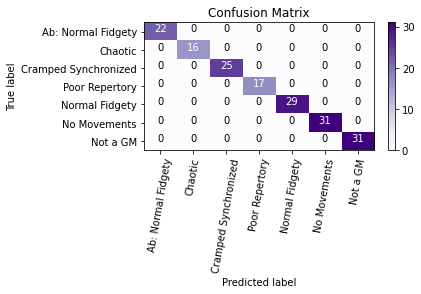

In [ ]:
cm_plot_labels = ['Ab: Normal Fidgety','Chaotic','Cramped Synchronized','Poor Repertory','Normal Fidgety','No Movements','Not a GM'] # class labels
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix') # plot the confusion matrix for training data

In [ ]:
import keras.backend as K 
import numpy as np

x = K.variable(np.eye(2, 2)) 

print('shape:', K.shape(x))
print('int_shape:', K.int_shape(x))

shape: tf.Tensor([2 2], shape=(2,), dtype=int32)
int_shape: (2, 2)
